In [ ]:
import json
import numpy as np
import pandas as pd
from skimage import io
from bigfish.detection import detect_spots
from bigfish.stack import remove_background_gaussian
from bigfish.detection import decompose_dense
from bigfish.stack import compute_focus
import bigfish.plot as plot
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.signal import savgol_filter
from typing import Tuple
import logging
import os
import napari
import re


In [95]:
def find_high_density_patch(mask: np.ndarray, patch_size: Tuple = (200, 200), attempts: int = 20):
    """

    randomly samples patches on the mask image and returns the coordinates of the top-left corner
    of the densest patch

    :param mask: segmentation image expected to have dimension (h * w)
    :param patch_size: height and width of the patch
    :param attempts: how many patches to try

    :return: coordinates of top left corner of densest patch found
    :rtype: Tuple[int, int]

    """
    h, w = mask.shape
    h_patch, w_patch = patch_size

    cell_pixels = 0
    selected_patch = (None, None)  # top left corner
    for attempt in range(attempts):

        row_sample = np.random.randint(0, h - h_patch)
        col_sample = np.random.randint(0, w - w_patch)

        sample_patch = mask[row_sample:row_sample + h_patch, col_sample:col_sample + w_patch]
        if np.sum(sample_patch > 0) > cell_pixels:
            cell_pixels = np.sum(sample_patch > 0)
            selected_patch = (row_sample, col_sample)

    return selected_patch


def find_in_focus_indices(focus: np.ndarray, adjustment_bottom: int = 5, adjustment_top: int = 10):
    """

    find the in-focus indices of calculated focus scores

    :param focus: series of values representing max intensity along z-axis
    :param adjustment_bottom: controls by how much the resulting range should be padded (bottom)
    :param adjustment_top: controls by how much the resulting range should be padded (top)

    :return: low and high z-level between which the spots are in focus
    :rtype: Tuple[int,int]
    """

    # find the inflection points of the smoothed curve
    ifx_1 = min([np.diff(focus).argmax(), np.diff(focus).argmin()])
    ifx_2 = max([np.diff(focus).argmax(), np.diff(focus).argmin()])

    # add a little cushion to one side.
    ifx_1 -= adjustment_bottom
    ifx_2 += adjustment_top

    print(adjustment_top, adjustment_bottom)
    return ifx_1, ifx_2

def show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2):
    # plotting of in-focus indices
    fig, axis = plt.subplots(ncols=3, figsize=(15, 5), facecolor='white')

    # plot max project focus scores
    sns.lineplot(x=range(len(projected_focus)), y=projected_focus, ax=axis[0])
    axis[0].set_xlabel('z-layer')
    axis[0].set_ylabel('score')
    axis[0].set_title('in-focus scores per z-layer')

    # plot smoothed focus scores
    sns.lineplot(x=range(len(projected_focus_smoothed)), y=projected_focus_smoothed, ax=axis[1])
    axis[1].set_xlabel('z-layer')
    axis[1].set_ylabel('score')
    axis[1].set_title('smoothed in-focus scores per z-layer')

    # plot projected focus image
    axis[2].imshow(np.amax(focus, axis=1))
    axis[2].set_title('y-max projection of the in-focus scores')

    # add indices of inflection point to plots
    axis[0].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[0].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[1].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[1].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[2].axhspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[2].axhspan(ifx_2 - 0.1, ifx_2, color='r')

    return fig

### Parameters

In [96]:
configfile = '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/config.json'
with open(configfile, 'r') as f:
    config = json.load(f)

In [97]:
imgfile = '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/img.json'
with open(imgfile, 'r') as f:
    img = json.load(f)
img

{'sourcefile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input/MG1655_GLU_OD_0.3_left_CY5, CY3.5 NAR, CY3, DAPI_02.vsi',
 'rootdir': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input',
 'basename': 'MG1655_GLU_OD_0.3_left_CY5, CY3.5 NAR, CY3, DAPI_02',
 'format': 'vsi',
 'time': {'01-configure': 7.00096583366394,
  '02-segment-DIC': 4.642106294631958,
  '02-segment-DAPI': 4.180879831314087,
  '03-detect-spots': 91.73150491714478},
 'stem': 'MG1655_GLU_OD_0.3_left_02',
 'seqnr': '02',
 'dicbasename': 'MG1655_GLU_OD_0.3_left_DIC_02.tif',
 'dicfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/DIC.tif',
 'inputdicfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input/MG1655_GLU_OD_0.3_left_DIC_02.tif',
 'cellmaskfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/DIC_masks.tif',
 'nuclearmaskfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/DAPI_masks.tif',


In [162]:
# parameters - adjust if necessary
scale = (200, 65, 65)
spot_radius = (1250, 170, 170) # is modified in later cell
sigma = (0.75, 2.3, 2.3)
patch_size = (200, 200)
detection_threshold  = { 'rpoD': None, 'rnlAB': None, 'hipBA': None }
# set to None for automatic determination by bigFISH
# detection threshold is usually optimised manually and might need to be set differently per channel

### Channel data

In [152]:
# load image data
mrna = 'rpoD'
mrna_data = io.imread(img[mrna]['rnafile'])
cell_mask_data = io.imread(img['cellmaskfile'])

/Users/adele/miniconda3/envs/ecoli/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


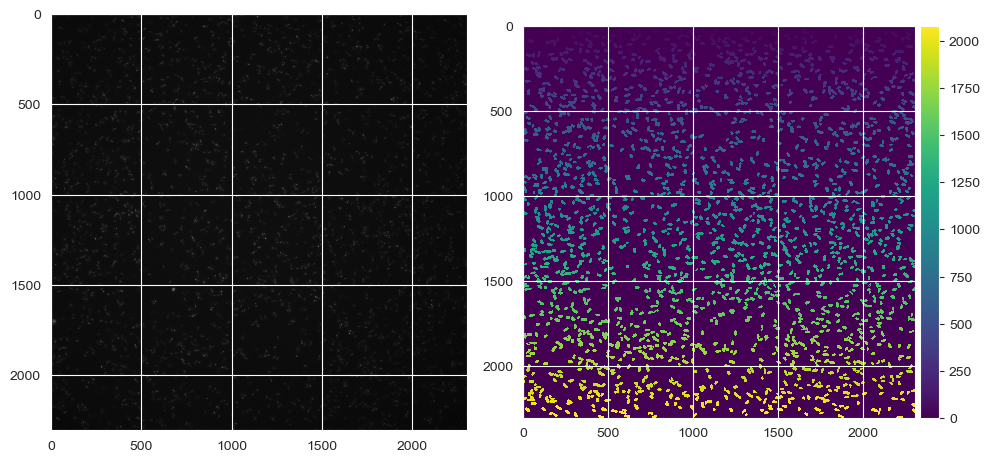

In [153]:
# inspect match
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(mrna_data[17, ...], ax=ax[0]);
io.imshow(cell_mask_data, ax=ax[1]);
plt.show();

selected_patch: selected_patch=(179, 794)


/Users/adele/miniconda3/envs/ecoli/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


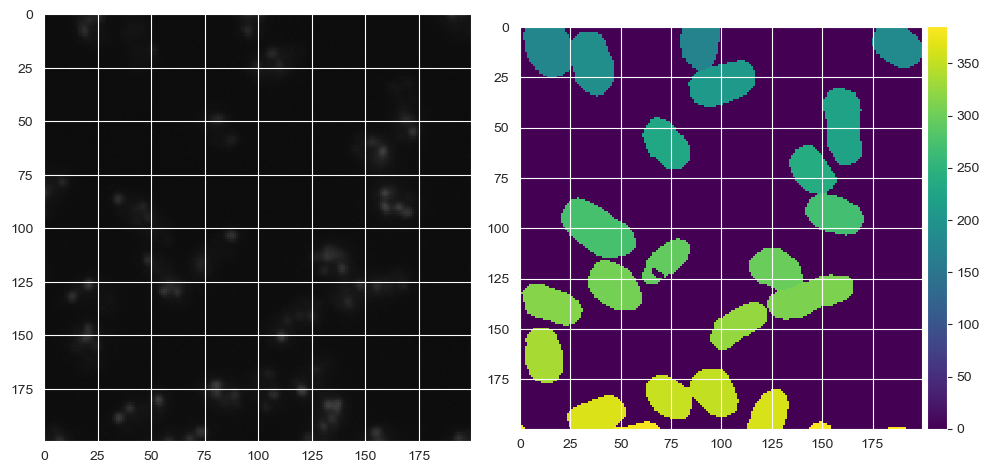

In [154]:
# find high density region
selected_patch = find_high_density_patch(cell_mask_data, patch_size=patch_size)
print(f"selected_patch: {selected_patch=}")

mask_patch = cell_mask_data[
             selected_patch[0]:selected_patch[0] + patch_size[0],
             selected_patch[1]:selected_patch[1] + patch_size[1]
             ]

img_patch = mrna_data[:,
            selected_patch[0]:selected_patch[0] + patch_size[0],
            selected_patch[1]:selected_patch[1] + patch_size[1]
            ]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(img_patch[17, ...], ax=ax[0]);
io.imshow(mask_patch, ax=ax[1]);
plt.show();

/Users/adele/miniconda3/envs/ecoli/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


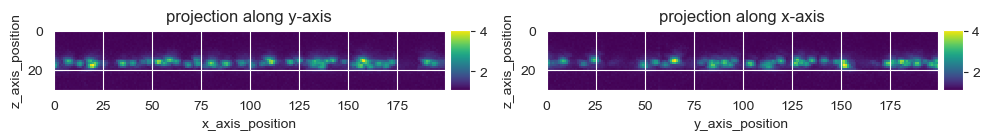

In [155]:
focus = compute_focus(img_patch)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(np.amax(focus, axis=1), ax=ax[0])
io.imshow(np.amax(focus, axis=2), ax=ax[1])

ax[0].set_xlabel('x_axis_position')
ax[0].set_ylabel('z_axis_position')
ax[0].set_title('projection along y-axis')

ax[1].set_xlabel('y_axis_position')
ax[1].set_ylabel('z_axis_position')
ax[1].set_title('projection along x-axis')

plt.tight_layout()
plt.show()

In [193]:
projected_focus = np.max(focus, axis=(1, 2))
projected_focus_smoothed = savgol_filter(projected_focus, 16, 2, 0)
# ifx_1, ifx_2 = find_in_focus_indices(projected_focus_smoothed, adjustment_bottom=0, adjustment_top=0)
ifx_1, ifx_2 = find_in_focus_indices(projected_focus_smoothed)

ifx_1 = max(ifx_1, 0)
ifx_2 = min(ifx_2, mrna_data.shape[0])
img[mrna]["z_max_focus"] = int(np.argmax(projected_focus_smoothed))
img[mrna]["ifx_1"] = int(ifx_1)
img[mrna]["ifx_2"] = int(ifx_2) 

if ifx_1 < 0 or ifx_2 > mrna_data.shape[0]:
    print(f'....warning: max focus is too close to highest or lowest slice')
print(f'....in focus indices: [{ifx_1}, {ifx_2}] (max focus at slice {img[mrna]["z_max_focus"]})')

10 5
....in focus indices: [6, 30] (max focus at slice 16)


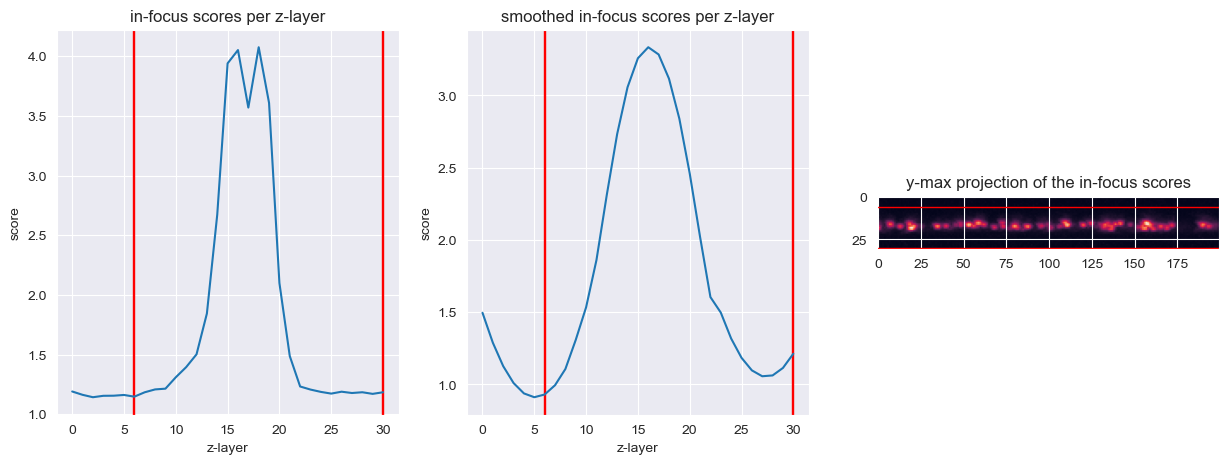

In [194]:
fig = show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2)
plt.show()

### Noise filtering

In [158]:

# perform background filtering on your image. Adjust filtering parameters if necessary
mrna_filtered = remove_background_gaussian(mrna_data, sigma=sigma)


In [159]:
viewer = napari.Viewer()

In [160]:
# here we add our image to the napari viewer, whilst also converting the pixel size to the nm scale
viewer.add_image(mrna_data, name='RNA channel', colormap='magenta', scale=scale)
viewer.add_image(mrna_filtered, name='filt RNA channel', scale=scale)

<Image layer 'filt RNA channel' at 0x5179ee2d0>

### Spot detection

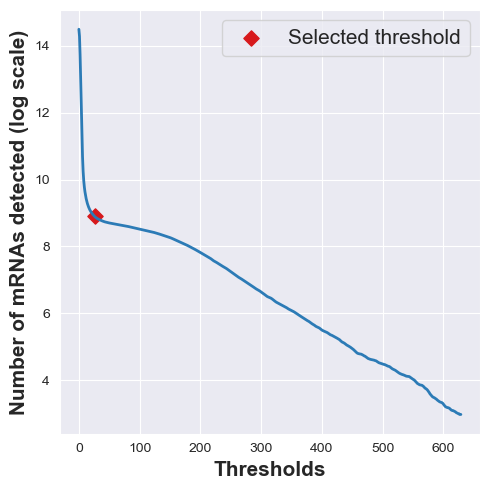

In [161]:
spot_radius = (880, 120, 120)
plot.plot_elbow(
    images=mrna_filtered[ifx_1:ifx_2, ...], 
    voxel_size=scale, 
    spot_radius=spot_radius)# 

In [183]:
# Best threshold values so far:
# rpoD validated visually on GLU02:
# not sure about the filtering, check
detection_threshold['rpoD'] = 110
# rnlAB validated visually on GLU02 
# filtering: we can get narrower spots but they become a lot dimmer, so not sure that helps
detection_threshold['rnlAB'] = 30
# hipBA:
# not sure about the filtering, check
detection_threshold['hipBA'] = 30

# this works well for bacteria:
spot_radius = (880, 120, 120)

mrna_filtered_selected = mrna_filtered[ifx_1:ifx_2, ...]
spots, threshold = detect_spots(
    mrna_filtered_selected,
    threshold=detection_threshold[mrna],
    voxel_size=scale,
    spot_radius=spot_radius,
    return_threshold=True
)

# always elegant:
filtered_padded_intensities = np.concatenate((np.zeros([ifx_1, mrna_data.shape[1], mrna_data.shape[2]]), mrna_filtered_selected, np.zeros([mrna_data.shape[0]- ifx_2, mrna_data.shape[1], mrna_data.shape[2]])), axis=0)
img[mrna]['filteredpaddedmrnafile'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_filtered_padded.npy')
np.save(img[mrna]['filteredpaddedmrnafile'], filtered_padded_intensities)
print(f'....saving filtered padded mRNA image to file {img[mrna]['filteredpaddedmrnafile']}')

# restore z-level
spots[:, 0] = spots[:, 0] + ifx_1

# adjustable out-of focus filtering
#  we remove the bottom two slices because their detected spots look like noise:
spots = spots[spots[:, 0] > ifx_1 + 2]
spot_intensities = np.resize(np.array([mrna_data[s[0], s[1], s[2]] for s in spots]), (len(spots), 1))
filtered_spot_intensities = np.resize(np.array([filtered_padded_intensities[s[0], s[1], s[2]] for s in spots]), (len(spots), 1))
spots_with_intensities = np.concatenate((spots, spot_intensities, filtered_spot_intensities), axis=1)

img[mrna]['spot_detection_threshold'] = threshold
img[mrna]['number_of_spots'] = len(spots)
print(f'....spot detection threshold: {threshold}')
print(f'....searched slices: [{ifx_1}, {ifx_2}]')
print(f'....number of spots found: {len(spots)}')
img[mrna]['spotsfile_latest'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_spots_thr={threshold}_ifx1={ifx_1}_ifx2={ifx_2}.npy')
np.save(img[mrna]['spotsfile_latest'], spots_with_intensities)
img[mrna]['spotsfile'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_spots.npy')
Path(img[mrna]['spotsfile']).unlink(missing_ok=True)
Path(img[mrna]['spotsfile']).symlink_to(Path(img[mrna]['spotsfile_latest']).parts[-1])
print(f'....saving {spots.shape[0]} spots to spots file {img[mrna]["spotsfile_latest"]}')



....saving filtered padded mRNA image to file /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_filtered_padded.npy
....spot detection threshold: 110
....searched slices: [7, 30]
....number of spots found: 4311
....saving 4311 spots to spots file /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_spots_thr=110_ifx1=7_ifx2=30.npy


#### Inspect selected spots intensities

In [172]:
# Plot histogram of pixel value for pixels that lies within a selected spot
# This distribution should be very uniform (one sharp peak, or maybe two peaks if Tx's are visible)
# spots = np.load('/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_spots_thr=10.0_ifx1=7_ifx2=30.npy')
df = pd.DataFrame(spots_with_intensities, columns=['z', 'y', 'x', 'intensity', 'filtered_intensity'])

df.sort_values(by=['z', 'y', 'x'], ascending=True, inplace=True)
df


,z,y,x,intensity,filtered_intensity
0,14.0,23.0,450.0,11599.0,3319.0
1,14.0,35.0,394.0,11154.0,3436.0
2,14.0,85.0,50.0,8697.0,2400.0
3,14.0,127.0,268.0,9672.0,3651.0
4,14.0,144.0,2195.0,7076.0,1905.0
...,...,...,...,...,...
4306,20.0,2049.0,1628.0,12813.0,4854.0
4307,20.0,2280.0,179.0,7763.0,2607.0
4308,22.0,31.0,498.0,10088.0,3179.0
4309,22.0,2043.0,1625.0,12541.0,4433.0


In [173]:
df.sort_values(by=['filtered_intensity'], ascending=True, inplace=False)

,z,y,x,intensity,filtered_intensity
1935,17.0,501.0,1519.0,10333.0,1318.0
375,16.0,17.0,2246.0,6213.0,1580.0
2849,17.0,1705.0,13.0,19856.0,1655.0
1564,17.0,0.0,1003.0,9831.0,1780.0
1553,16.0,2269.0,2093.0,6271.0,1825.0
...,...,...,...,...,...
1126,16.0,1296.0,1148.0,33491.0,16172.0
1039,16.0,1143.0,798.0,32198.0,16288.0
3573,18.0,970.0,916.0,30795.0,16388.0
2316,17.0,1047.0,1636.0,30139.0,16444.0


In [174]:
spotfiles = Path(config['outputdir'], img['stem']).glob(f'{mrna}_spots_thr*')
pattern = re.compile(rf'_spots_thr=(?P<threshold>[0-9.]+)_ifx1=(?P<ifx1>[0-9]+)_ifx2=(?P<ifx2>[0-9]+).npy')
df_all = pd.DataFrame()

for f in spotfiles:
    filename = str(f.parts[-1])
    match = pattern.search(str(f))
    d = match.groupdict()
    print(filename, d)
    spots = np.load(f)
    df = pd.DataFrame(spots, columns=['z', 'y', 'x', 'intensity', 'filtered_intensity'])
    if int(d['ifx2']) > 21:
        df['params'] = f"{d['threshold']}_{d['ifx1']}_{d['ifx2']}"
        df_all = pd.concat([df_all, df], axis=0)
df_all

rpoD_spots_thr=110_ifx1=7_ifx2=30.npy {'threshold': '110', 'ifx1': '7', 'ifx2': '30'}
rpoD_spots_thr=10_ifx1=12_ifx2=20.npy {'threshold': '10', 'ifx1': '12', 'ifx2': '20'}
rpoD_spots_thr=15.0_ifx1=12_ifx2=21.npy {'threshold': '15.0', 'ifx1': '12', 'ifx2': '21'}
rpoD_spots_thr=100_ifx1=7_ifx2=30.npy {'threshold': '100', 'ifx1': '7', 'ifx2': '30'}
rpoD_spots_thr=100_ifx1=6_ifx2=30.npy {'threshold': '100', 'ifx1': '6', 'ifx2': '30'}
rpoD_spots_thr=10.0_ifx1=7_ifx2=30.npy {'threshold': '10.0', 'ifx1': '7', 'ifx2': '30'}
rpoD_spots_thr=26.0_ifx1=7_ifx2=30.npy {'threshold': '26.0', 'ifx1': '7', 'ifx2': '30'}
rpoD_spots_thr=50_ifx1=7_ifx2=30.npy {'threshold': '50', 'ifx1': '7', 'ifx2': '30'}


,z,y,x,intensity,filtered_intensity,params
0,14.0,23.0,450.0,11599.0,3319.0,110_7_30
1,14.0,35.0,394.0,11154.0,3436.0,110_7_30
2,14.0,85.0,50.0,8697.0,2400.0,110_7_30
3,14.0,127.0,268.0,9672.0,3651.0,110_7_30
4,14.0,144.0,2195.0,7076.0,1905.0,110_7_30
...,...,...,...,...,...,...
5207,20.0,2280.0,179.0,7763.0,2607.0,50_7_30
5208,21.0,1498.0,1166.0,12656.0,4090.0,50_7_30
5209,22.0,31.0,498.0,10088.0,3179.0,50_7_30
5210,22.0,2043.0,1625.0,12541.0,4433.0,50_7_30


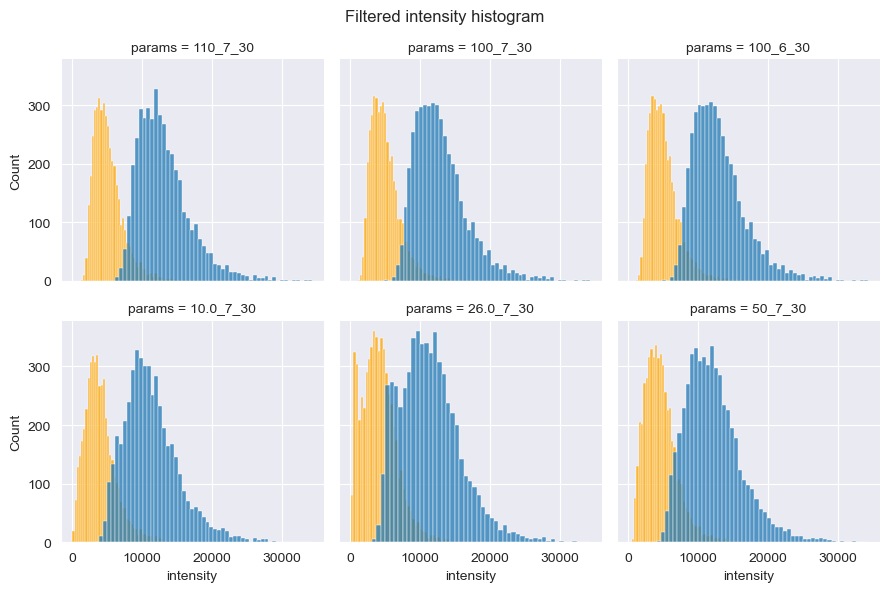

In [176]:
g = sns.FacetGrid(df_all, col='params', col_wrap=3)
g.map_dataframe(sns.histplot, x='filtered_intensity', color='orange', stat='count')
g.map_dataframe(sns.histplot, x='intensity', stat='count')
g.fig.suptitle('Filtered intensity histogram')
g.tight_layout();

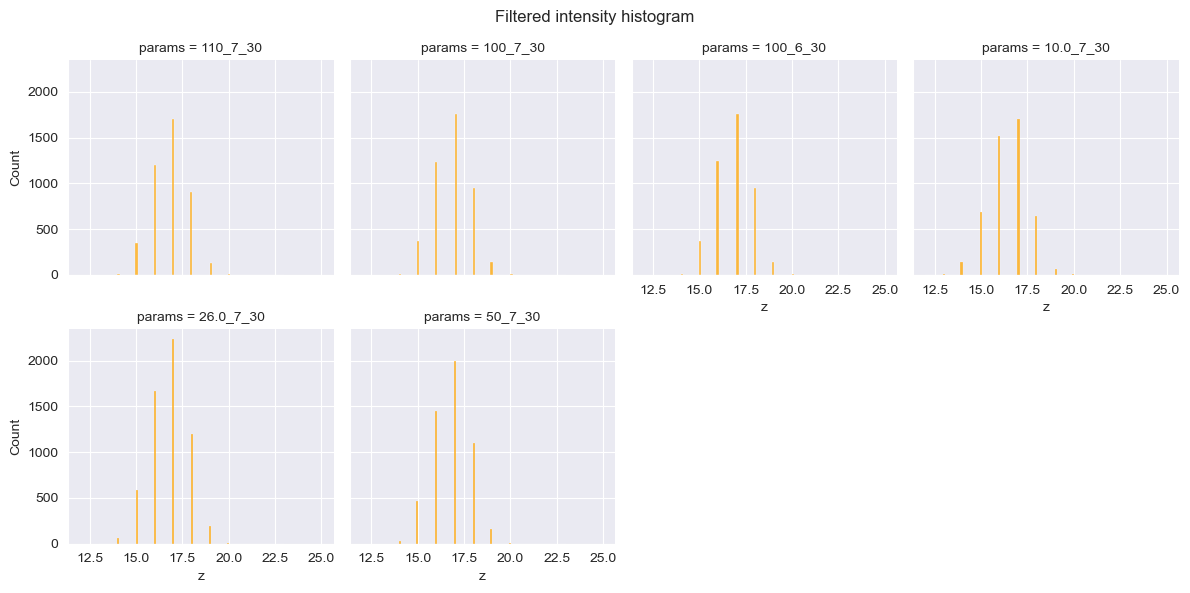

In [177]:
g = sns.FacetGrid(df_all, col='params', col_wrap=4)
g.map_dataframe(sns.histplot, x='z', color='orange', stat='count')
g.fig.suptitle('Filtered intensity histogram')
g.tight_layout();

### Spot decomposition

In [184]:
decomposed_spots, dense_regions, reference_spot = decompose_dense(
    mrna_filtered,
    spots[:, 0:3],
    voxel_size=scale,
    spot_radius=spot_radius,
    alpha=0.5, # alpha impacts the number of spots per candidate region
    beta=2,    # beta impacts the number of candidate regions to decompose
    gamma=1    # gamma the filtering step to denoise the image
)

img[mrna]['decompspotsfile'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_decomposed_spots.npy')
img[mrna]['ddregionsfile'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_ddregions.npy')
img[mrna]['refspotfile'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_rf_spots.tif')
np.save(img[mrna]['decompspotsfile'], decomposed_spots)
np.save(img[mrna]['ddregionsfile'], dense_regions)
io.imsave(img[mrna]['refspotfile'], reference_spot)
print(f"....decomposed spot data: {img[mrna]['decompspotsfile']}")
print(f"....dense regions data: {img[mrna]['ddregionsfile']}")
print(f"....reference spot: {img[mrna]['refspotfile']}")


....decomposed spot data: /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_decomposed_spots.npy
....dense regions data: /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_ddregions.npy
....reference spot: /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_rf_spots.tif


/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_9885/3346449501.py:16: UserWarning: /Users/adele/PycharmProjects/Ecoli_smFISH/tests/output/MG1655_GLU_OD_0.3_left_02/rpoD_rf_spots.tif is a low contrast image
  io.imsave(img[mrna]['refspotfile'], reference_spot)
